In [336]:
import pandas as pd
import numpy as np
import regex
import re
import matplotlib.pyplot as plt
import os.path

In [337]:
def split_profession(str):
    return str.split(',')

In [338]:
if os.path.exists('./pickles/filtered_actors.pkl'):
    print("Reading from pickle...")
    actors = pd.read_pickle("./pickles/filtered_actors.pkl")
else:
    people_df = pd.read_csv(
        './data/name.basics.tsv.gz',
        sep='\t',
        converters={'primaryProfession': split_profession}
    )
    people_prof_exploded = people_df.explode('primaryProfession')
    actors = people_prof_exploded[
        (people_prof_exploded.primaryProfession == 'actress') | (people_prof_exploded.primaryProfession == 'actor')]
    actors.to_pickle("./pickles/filtered_actors.pkl")
actors.head()

Reading from pickle...


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,actor,"tt0050419,tt0053137,tt0043044,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,actress,"tt0117057,tt0037382,tt0071877,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,actress,"tt0049189,tt0059956,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949,1982,actor,"tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,actor,"tt0050986,tt0083922,tt0069467,tt0050976"


In [339]:
movie_cast = pd.read_pickle("./pickles/complete_cast.pkl").rename(columns={"count": "castCount"})
imdb_movies = pd.read_pickle("./pickles/filtered_movies.pkl")
scraped_movies = pd.read_pickle("./pickles/complete_movies.pkl")
movie_ratings = pd.read_csv("./data/title.ratings.tsv.gz", sep='\t')
movie_cast

,tconst,cast,castCount
0,tt0788137,"[nm2213445, nm2216523, nm2212320, nm2219080, n...",6
1,tt0788133,"[nm2100867, nm1952207, nm2218383, nm5041940, n...",6
2,tt0788141,"[nm0149867, nm0708218, nm0899804]",3
3,tt0788134,"[nm1833642, nm1044987, nm2756644, nm1833094, n...",5
4,tt0790463,"[nm2214417, nm2213293]",2
...,...,...,...
538012,tt7172590,[nm7502202],1
538013,tt11088928,"[nm0608846, nm2792327, nm9117281]",3
538014,tt2577910,[nm5174887],1
538015,tt11369300,[nm11170433],1


In [520]:
movies = scraped_movies\
            .merge(imdb_movies, how='left', left_on='tconst', right_on='tconst')\
            .merge(movie_ratings, left_on='tconst', right_on='tconst', how='left')\
            .merge(movie_cast, left_on='tconst', right_on='tconst', how='left')

movies[['castCount', 'isAdult']] = movies[['castCount', 'isAdult']].fillna(value=0)
# movies = movies.replace('^\\\\N$', np.nan, regex=True)
movies = movies.astype({'castCount': 'int32', 'isAdult': 'int32', 'runtimeMinutes': 'Int64'})
# movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce',  downcast='integer')
movies['runtimeMinutes'] = pd.array(list(movies['runtimeMinutes']), dtype=pd.Int64Dtype())
movies

TypeError: object cannot be converted to an IntegerDtype

In [500]:
len(movies)

537913

### Computing successful movies

We consider the success of the movies in 3 different aspects. Analysis will be carried out for each of these aspects separately. The 3 aspects are as follows.
* Awards
* Popularity
* Profit

Now we compute the respective set of successful movies for each of those aspects

#### Awards

We specify an arbitrary metric to represent the success of a movie as a score in terms of its awards and nominations. Based on the intuition that an Oscar win is the most prestigious award a movie can ever get, we give a weight of 10 for Oscar awards. For any other awards we give a weight of 2 and all the nominations will receive a weight of 1. The weighted sum off these 3 aspects will be the 'Recognition Score' of a movie.

In [501]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) + (movies.wins *WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)

Let us have a look at the distribution of the Recognition Scores computer for all the movies.

Text(0.5, 0, 'Recognition score')

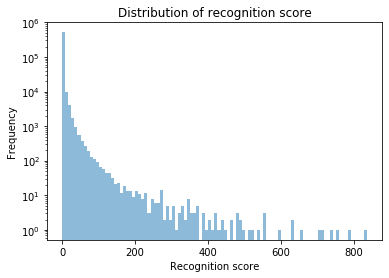

In [502]:
fig, ax = plt.subplots()
recognized_movies.recognition.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of recognition score')
ax.set_xlabel('Recognition score')

We can see that for a vast majority of the movies, either they have never got nominated for, or won any awards or IMDB does not have the award related information for those movies. So taking the movies with a Recognition Score of 0 for the comparison does not make sense. We will therefore only keep the movies that has a non-zero Recognition score and we will select the top 5% of those movies as the most successful movies in terms of awards recogntion.

In [503]:
CUT_OFF_THRESH = 0.05
nzero_recognized_movies = recognized_movies[recognized_movies.recognition > 0]
top_recognized_movies = nzero_recognized_movies[:int(len(nzero_recognized_movies) * CUT_OFF_THRESH)]
top_recognized_movies.reset_index(drop=True, inplace=True)

unrecognized_movies = pd.concat([
    nzero_recognized_movies[int(len(nzero_recognized_movies) * CUT_OFF_THRESH):],
    recognized_movies[recognized_movies.recognition == 0]])
unrecognized_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of awards: {0} out of {1}'.format(len(top_recognized_movies), len(movies)))
print('Number of movies considered unsuccessful in terms of awards: {0} out of {1}'.format(len(unrecognized_movies), len(movies)))

Number of movies considered successful in terms of awards: 2395 out of 537913
Number of movies considered unsuccessful in terms of awards: 535518 out of 537913


#### Popularity

As a direct measure of the popularity of a movie, we will consider the number of votes the movie has received on IMDB.

In [504]:
popular_movies = movies.dropna(subset=['numVotes'])\
                    .astype({'numVotes': 'int32'})\
                    .sort_values('numVotes', ascending=False)
print('Number of movies considered for the analysis after dropping mising values: {0} out of {1}'\
          .format(len(popular_movies), len(movies)))

Number of movies considered for the analysis after dropping mising values: 242040 out of 537913


Let us first check the distribution of the number of votes on all the movies considered.

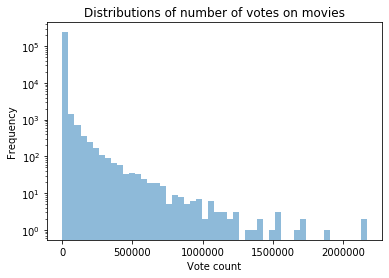

In [505]:
ax = popular_movies['numVotes'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of number of votes on movies')
ax.set_xlabel('Vote count')
ax.set_yscale('log')

Here also we see that for a vast majority of the movies, the vote count is either missing or the movie did not get any votes at all on IMDB. Since a comparison between movies with 0 votes does not make sense, we will only use the movies that have atleast 1 vote and take the top 5% as the successful movies in terms of poluarity.

In [506]:
CUT_OFF_THRESH = 0.05
nzero_popular_movies = popular_movies[popular_movies.numVotes > 0]
top_popular_movies = nzero_popular_movies[:int(len(nzero_popular_movies) * CUT_OFF_THRESH)]
top_popular_movies.reset_index(drop=True, inplace=True)

unpopupar_movies = pd.concat([
    nzero_popular_movies[int(len(nzero_popular_movies) * CUT_OFF_THRESH):],
    popular_movies[popular_movies.numVotes == 0]])
unpopupar_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of popuarity: {0} out of {1}'.format(len(top_popular_movies), len(movies)))
print('Number of movies considered unsuccessful in terms of popularity: {0} out of {1}'.format(len(unpopupar_movies), len(movies)))

Number of movies considered successful in terms of popuarity: 12102 out of 537913
Number of movies considered unsuccessful in terms of popularity: 229938 out of 537913


#### Profit

Apart from movies missing their budget and wordwide gross information in the database, the currencies the amounts are represented in vastly differs. Converting different currencies to one currency would require the conversion rates that existed in the times the movie was produced and posseses a challenge. Hence, we will filter out the movies that have different currencies in the 'Budget' and 'WorldwideGross' fields and get the difference in the 2 amounts as a measure of success.

In [507]:
def grossProfit(budget, income):
    if budget is None or income is None:
        return np.nan
    cur_regex = r'^(\p{Sc}|[a-zA-Z]{2,3})'
    budget_result = regex.search(cur_regex, budget)
    income_result = regex.search(cur_regex, income)
    if budget_result is not None and income_result is not None:
        if budget_result.group(0) == income_result.group(0):
            currency = budget_result.group(0)
            budget_float = float(budget[len(currency):].replace(',',''))
            income_float = float(income[len(currency):].replace(',',''))            
            return income_float - budget_float
    return np.nan

In [508]:
movie_financial = movies.dropna(subset=['budget', 'worldwideGross'], how='any').copy()
movie_financial['grossProfit'] = movie_financial.apply(lambda x: grossProfit(x.budget, x.worldwideGross), axis=1)
movie_financial.dropna(subset=['grossProfit'], inplace=True)
movie_financial.sort_values('grossProfit', ascending=False, inplace=True)

print('Number of movies considered for the analysis after dropping rows with incompatible currencies: {0} out of {1}'\
          .format(len(movie_financial), len(movies)))

Number of movies considered for the analysis after dropping rows with incompatible currencies: 9723 out of 537913


Let us first check the distribution of the profits on all the movies considered.

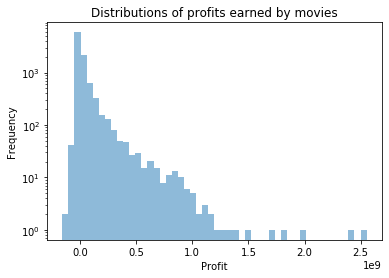

In [509]:
ax = movie_financial['grossProfit'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of profits earned by movies')
ax.set_xlabel('Profit')
ax.set_yscale('log')

Most of the movies have a profit close to 0 and a small number of movies considered have been at a loss. We will consider the top 10% highest profit earned movies as financially successful movies.

In [510]:
CUT_OFF_THRESH = 0.1
top_profit_movies = movie_financial[:int(len(movie_financial) * CUT_OFF_THRESH)]
top_profit_movies.reset_index(drop=True, inplace=True)

loss_movies = movie_financial[int(len(movie_financial) * CUT_OFF_THRESH):]
loss_movies.reset_index(drop=True, inplace=True)

print('Number of movies considered successful in terms of profit: {0} out of {1}'.format(len(top_profit_movies), len(movie_financial)))
print('Number of movies considered unsuccessful in terms of profit: {0} out of {1}'.format(len(loss_movies), len(movie_financial)))

Number of movies considered successful in terms of profit: 972 out of 9723
Number of movies considered unsuccessful in terms of profit: 8751 out of 9723


## Cast Gender Analysis

### Awards Based

#### Movie Cast Analysis on Unuccessful Movies

In [351]:
movie_cast_expl = unrecognized_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of unsuccessful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of unsuccessful movies considered for cast analysis: 396253


Due to the inner join performed, some missing information in the actors dataset has resulted in a reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [352]:
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,2,1,3,0.666667,0.333333
tt0000147,1,0,1,1.000000,0.000000
tt0000335,5,1,6,0.833333,0.166667
tt0000502,2,0,2,1.000000,0.000000
tt0000574,12,3,15,0.800000,0.200000


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

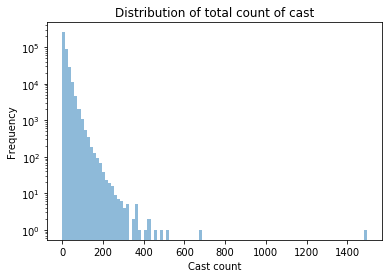

In [353]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

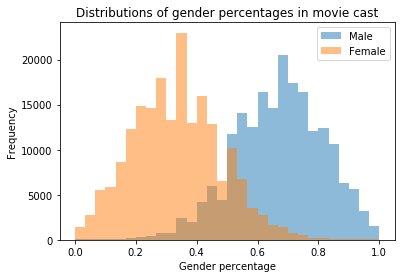

In [354]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

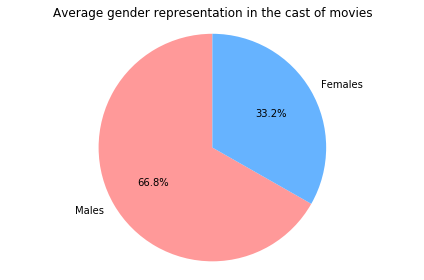

In [355]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [356]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6666666666666666
Median percentage of females: 0.3333333333333333


Next, we check if this situation is different in the movies that are considered successful in terms of awards recognition. 



#### Movie Cast Analysis on Successful Movies

In [357]:
movie_cast_expl = top_recognized_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of successful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of successful movies considered for cast analysis: 2361


Due to the inner join performed, some missing information in the actors dataset has resulted in a slightly reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [358]:
# Groupby will not show when one of the value is 0. so do a pivot
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0025316,61,20,81,0.753086,0.246914
tt0026529,32,7,39,0.820513,0.179487
tt0027300,69,27,96,0.718750,0.281250
tt0029146,40,8,48,0.833333,0.166667
tt0031381,92,60,152,0.605263,0.394737


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

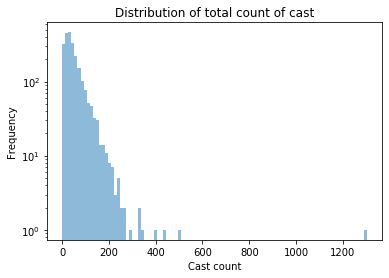

In [359]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

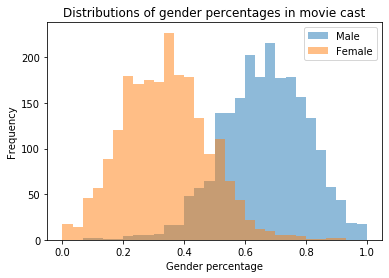

In [360]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

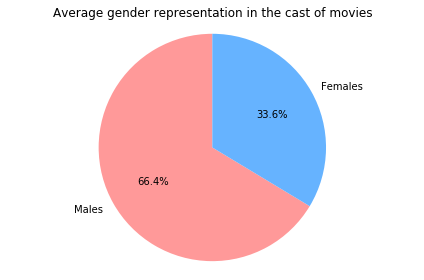

In [361]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [362]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6666666666666666
Median percentage of females: 0.3333333333333333


In conclusion, both in successful movies as well as unsuccessful movies, in terms of awards, the mean gender percentages of the cast of the movies show little to no difference. Specifically, in successful movies, on average 66.4% of the movie cast are males where as in unsuccessful movies 66.8% of the cast are males. Accordingly, the gender percentages of cast does not seem to make any impact on whether the movie becomes successful in terms of awards

### Popularity Based

#### Movie Cast Analysis on Unuccessful Movies

In [363]:
movie_cast_expl = unpopupar_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of unsuccessful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of unsuccessful movies considered for cast analysis: 211463


Due to the inner join performed, some missing information in the actors dataset has resulted in a reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [364]:
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0000009,2,1,3,0.666667,0.333333
tt0000147,1,0,1,1.000000,0.000000
tt0000335,5,1,6,0.833333,0.166667
tt0000574,12,3,15,0.800000,0.200000
tt0000615,5,1,6,0.833333,0.166667


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

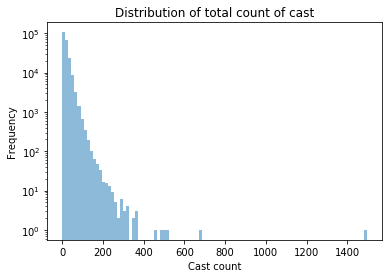

In [365]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

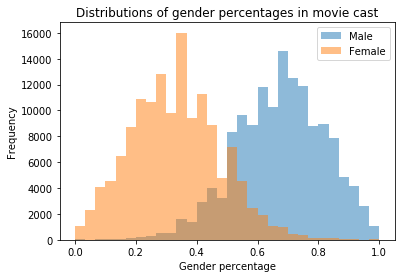

In [366]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

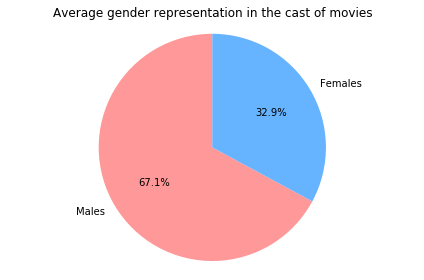

In [367]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [368]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6764705882352942
Median percentage of females: 0.3235294117647059


Next, we check if this situation is different in the movies that are considered successful in terms of awards recognition.

#### Movie Cast Analysis on Successful Movies

In [369]:
movie_cast_expl = top_popular_movies.explode('cast')
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')
print('Number of successful movies considered for cast analysis: {0}'.format(cast_info.tconst.nunique()))

Number of successful movies considered for cast analysis: 12069


Due to the inner join performed, some missing information in the actors dataset has resulted in a slightly reduced number of movies. Let us now compute the percentages of gender in the cast of each movie.

In [370]:
# Groupby will not show when one of the value is 0. so do a pivot
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders.head()

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0004972,41,17,58,0.706897,0.293103
tt0006864,86,50,136,0.632353,0.367647
tt0009611,53,1,54,0.981481,0.018519
tt0009968,12,3,15,0.800000,0.200000
tt0010323,9,2,11,0.818182,0.181818


To inspect the credibility of the cast information of the movies, let us have a look at the distribution of the total number of cast members in the movies.

Text(0.5, 0, 'Cast count')

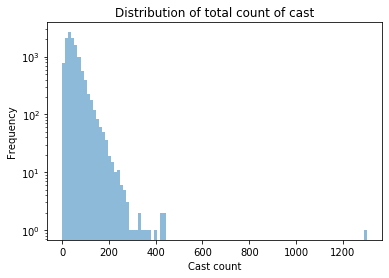

In [371]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

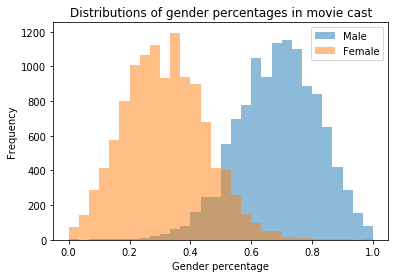

In [372]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of popular movies as well. The following pie chart demonstrates the mean representation percentage of both the genders.

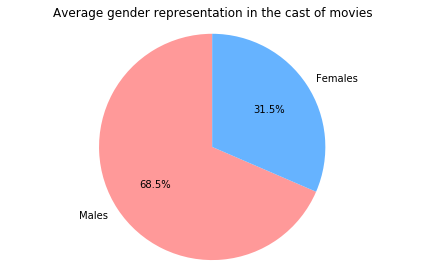

In [373]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [374]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6923076923076923
Median percentage of females: 0.3076923076923077


In conclusion, both in successful movies as well as unsuccessful movies, in terms of popularity, the mean gender percentages of the cast of the movies show little difference. Specifically, in successful movies, on average 68.5% of the movie cast are males where as in unsuccessful movies 67.1% of the cast are males. Accordingly, the gender percentages of cast does not seem to make any impact on whether the movie becomes successful in terms of popularity.

### Profit Based

#### Movie Cast Analysis on Unsuccessful Movies

In [375]:

loss_movies = loss_movies.explode('cast')
loss_movies = loss_movies.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = loss_movies.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0010323,9,2,11,0.818182,0.181818
tt0012190,30,12,42,0.714286,0.285714
tt0012349,36,31,67,0.537313,0.462687
tt0014624,18,7,25,0.720000,0.280000
tt0015864,97,39,136,0.713235,0.286765
...,...,...,...,...,...
tt9799992,7,5,12,0.583333,0.416667
tt9854992,0,2,2,0.000000,1.000000
tt9857522,4,3,7,0.571429,0.428571


Text(0.5, 0, 'Cast count')

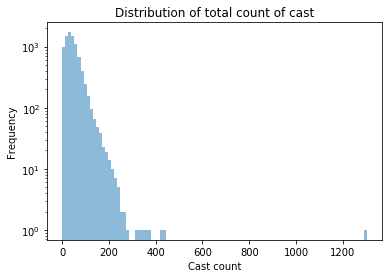

In [376]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can see that in many of the movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

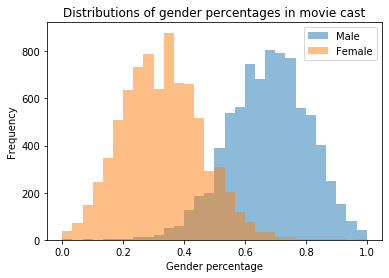

In [377]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

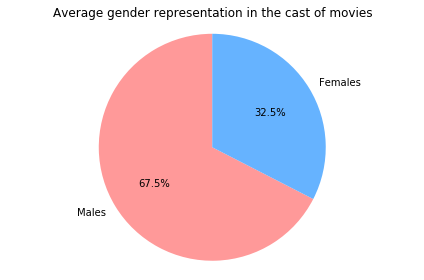

In [378]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [379]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6785714285714286
Median percentage of females: 0.32142857142857145


Next, we check if this situation is different in the movies that are considered successful in terms of awards recognition.

#### Movie Cast Analysis on Successful Movies

In [380]:

top_profit_movies = top_profit_movies.explode('cast')
top_profit_movies = top_profit_movies.merge(actors, left_on='cast', right_on='nconst', how='inner')

tconst_genders = top_profit_movies.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='nconst',
                     fill_value=0, 
                     aggfunc=len)

tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']
tconst_genders

primaryProfession,actor,actress,total,male,female
tconst,,,,,
tt0029583,11,3,14,0.785714,0.214286
tt0031381,92,60,152,0.605263,0.394737
tt0032910,10,3,13,0.769231,0.230769
tt0055254,21,14,35,0.600000,0.400000
tt0059742,22,21,43,0.511628,0.488372
...,...,...,...,...,...
tt7605074,22,4,26,0.846154,0.153846
tt7959026,68,29,97,0.701031,0.298969
tt8079248,54,35,89,0.606742,0.393258


Text(0.5, 0, 'Cast count')

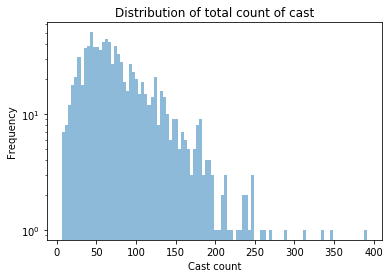

In [381]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of total count of cast')
ax.set_xlabel('Cast count')

We can still see that in a significant number of movies, the cast information is either completely missing or very low. Hence, it is safe to assume that the ones that have a very low number of cast members cannot be considered as credible movie datapoints for an analysis. So we will use the movies that has a cast count of more than 10 for the gender based analysis. Let us now look at the distribution of the male and female percentages in the cast of movies.

Text(0.5, 0, 'Gender percentage')

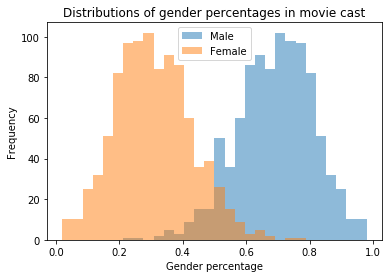

In [382]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

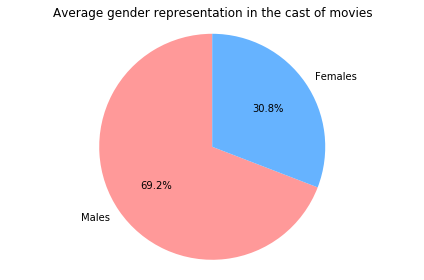

In [383]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

In [384]:
print('Median percentage of males: {0}'.format(tconst_genders_cred.male.median()))
print('Median percentage of females: {0}'.format(tconst_genders_cred.female.median()))

Median percentage of males: 0.6976744186046512
Median percentage of females: 0.3023255813953488


In conclusion, we can see that in Financially successful movies, there is a slightly higher percentage of male actors in the movie cast than in not so successful movies.

## Adult Movie Analysis

In [432]:
print('Total number of adults only movies: {0}'.format(len(movies[movies.isAdult == 1])))

Total number of adults only movies: 8638


### Awards based

#### Adult vs non-adult analysis of unsuccessful movies

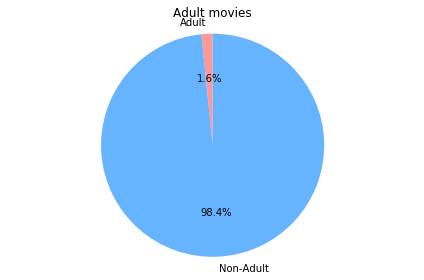

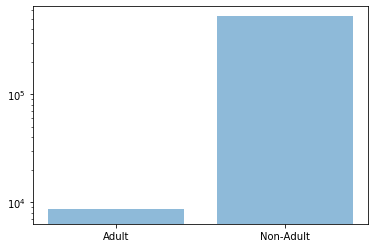

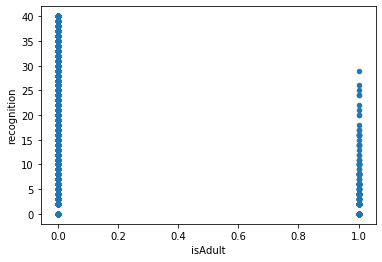

In [447]:
adult_count = len(unrecognized_movies[unrecognized_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(unrecognized_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

unrecognized_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

#### Adult vs non-adult analysis of successful movies

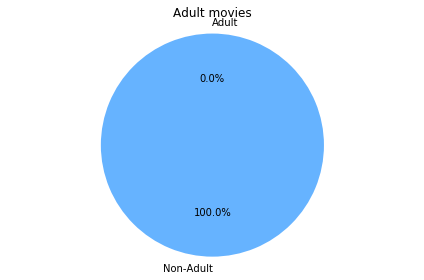

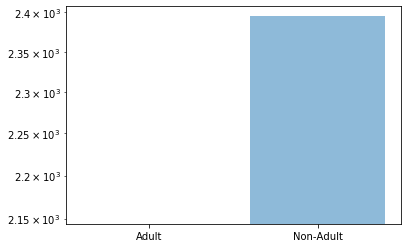

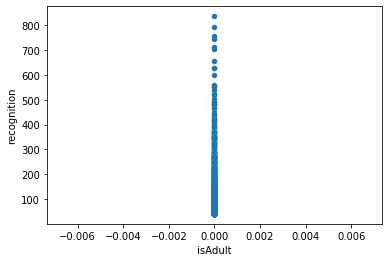

In [446]:
adult_count = len(top_recognized_movies[top_recognized_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_recognized_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

top_recognized_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

In successful movies in terms of awards, we see that there are no adult labeled movies at all where as in the unsuccessful movies set, 1.6% are adult labeled. In general, none of the adults only movies have made it to the successful list.

### Popularity Based

#### Adult vs non-adult analysis of unsuccessful movies

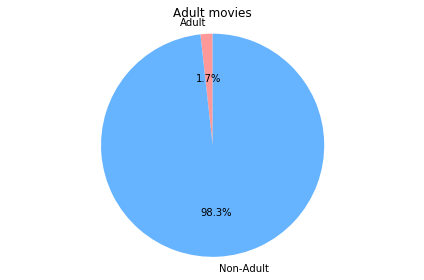

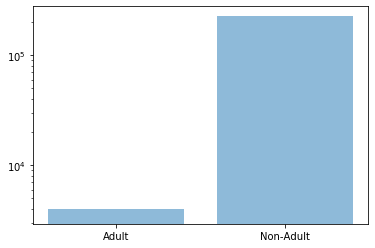

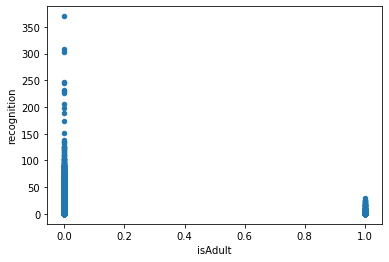

In [442]:
adult_count = len(unpopupar_movies[unpopupar_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(unpopupar_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

unpopupar_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

#### Adult vs non-adult analysis of successful movies

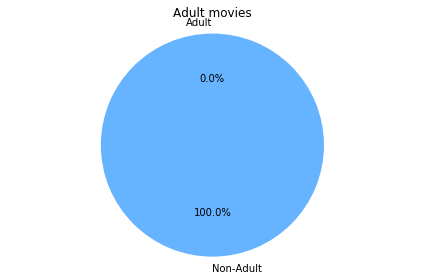

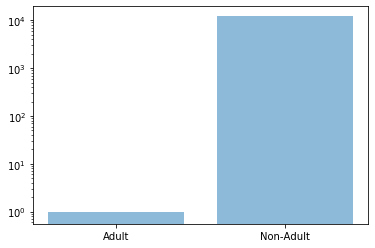

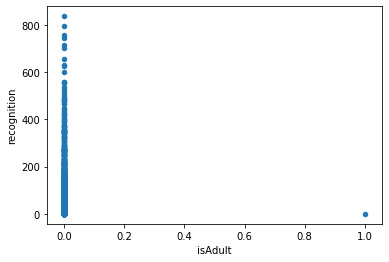

In [443]:
adult_count = len(top_popular_movies[top_popular_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_popular_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

top_popular_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

In successful movies in terms of popularity, we see that there is only 1 adult labeled movie where as in the unsuccessful movies set, 1.7% are adult labeled. 

## Profit Based

#### Adult vs non-adult analysis of unsuccessful movies

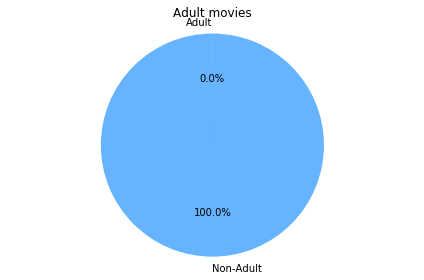

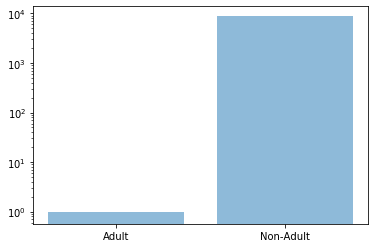

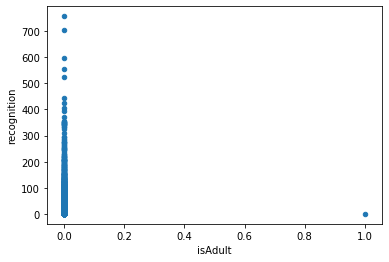

In [445]:
adult_count = len(loss_movies[loss_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(loss_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()


fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

loss_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

#### Adult vs non-adult analysis of successful movies

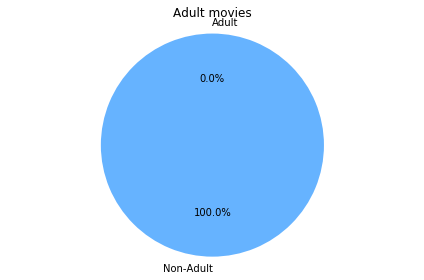

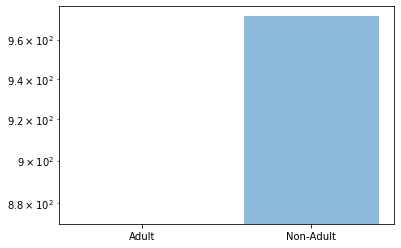

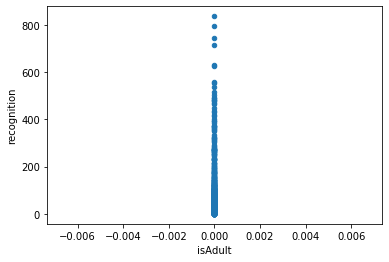

In [444]:
adult_count = len(top_profit_movies[top_profit_movies.isAdult == 1])
labels = ['Adult', 'Non-Adult']
sizes = [adult_count, len(top_profit_movies) - adult_count]

colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Adult movies')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
plt.yscale('log')
plt.bar(labels, sizes, alpha=0.5)
plt.show()

top_profit_movies.plot.scatter(x='isAdult', y='recognition')
plt.show()

Once again, with the information considered, none of the Adult rated movies have made siginificant profits.

#### Conclusion

In conclusion, we see that adult rated movies seldom become very succesful in terms of awards, popularity and profits.

## Movie Runtime Analysis

### Award based

#### Movie Runtime analysis of unsuccesful movies

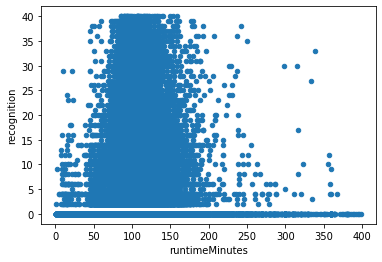

In [514]:
unrecognized_movies[unrecognized_movies.runtimeMinutes < 400]\
    .plot.scatter(x='runtimeMinutes', y='recognition')
# unrecognized_movies.astype({'runtimeMinutes':'int32'})


#### Movie Runtime analysis of succesful movies

### Popularity based

#### Movie Runtime analysis of unsuccesful movies

#### Movie Runtime analysis of succesful movies

### Profit based

#### Movie Runtime analysis of unsuccesful movies

#### Movie Runtime analysis of succesful movies

## Movie Ratings Analysis

In [385]:
movie_votes = movies.dropna(subset=['numVotes'])
movie_votes = movie_votes.astype({'numVotes': 'int32'})
movie_votes

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,castCount,recognition
42,tt11216664,"[nm11100385, nm11100384, nm11100383]",0,0,0,2019-01-05,USA,[],"$10,000",None,...,0.0,2019,\N,46,Documentary,7.2,18,[nm1110038],1,0
48,tt11296054,"[nm11159340, nm11137407, nm11159342]",0,0,0,2019-11-22,India,[],"INR1,000,000",None,...,0.0,2019,\N,137,"Action,Drama,Sci-Fi",8.6,39,"[nm1115934, nm1113740, nm1113742, nm1113730, n...",13,0
49,tt3015100,"[nm4977285, nm0371154, nm5475873]",0,0,0,2013-05-12,USA,[],None,None,...,0.0,2013,\N,\N,Drama,7.5,15,"[nm4977285, nm0371154, nm5475873, nm4914305, n...",68,0
54,tt3014910,"[nm0000104, nm0796316, nm0000391]",0,0,0,2016-04-01,Spain,[],"EUR8,500,000","$1,341,205",...,0.0,2016,\N,97,"Biography,Drama,History",5.9,2188,"[nm0000104, nm0796316, nm0000391, nm0419512, n...",24,0
63,tt11351822,"[nm11163867, nm10090121, nm9247610]",0,0,0,2019-11-28,Malaysia,[],None,None,...,0.0,2019,\N,101,"Drama,Romance",9.3,12,"[nm1116386, nm1009012, nm9247610, nm9469314]",4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537908,tt4503096,"[nm0316284, nm2826970, nm2807641]",0,0,0,2016-03-31,Italy,[],None,"$421,624",...,0.0,2016,\N,119,"Biography,Comedy",6.5,369,"[nm0316284, nm2826970, nm2807641, nm4216144, n...",32,0
537909,tt4500922,"[nm3729721, nm3859624, nm2546012]",0,6,0,2018-01-26,USA,"[human experimentation, virus, post apocalypse...","$62,000,000","$288,175,335",...,0.0,2018,\N,143,"Action,Sci-Fi,Thriller",6.2,97646,"[nm3729721, nm3859624, nm2546012, nm1032473, n...",42,6
537910,tt4502426,"[nm1257460, nm2932493, nm4519154]",0,5,0,2018-06-29,Sri Lanka,[],"EUR450,000",None,...,0.0,2016,\N,84,Drama,7.3,63,"[nm5165313, nm1257460, nm1269796, nm1785489, n...",20,5
537911,tt4228338,"[nm6938120, nm6938121, nm6938122]",0,0,0,2013-12-18,Belgium,[],"EUR80,000",None,...,0.0,2013,\N,70,"Documentary,Sport",8.5,11,"[nm6938120, nm6938121, nm6938122, nm6938119, n...",5,0


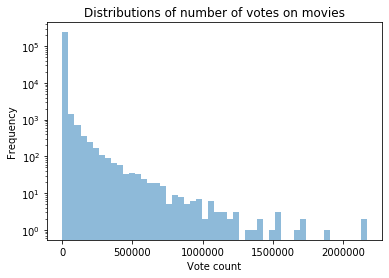

In [386]:
ax = movie_votes['numVotes'].plot.hist(bins=50, alpha=0.5)
ax.set_title('Distributions of number of votes on movies')
ax.set_xlabel('Vote count')
ax.set_yscale('log')

Here also we see that for a vast majority of the movies, the vote count is either missing or the movie did not get any votes at all on IMDB

In [387]:
most_popular = movie_votes.sort_values('numVotes', ascending=False)

## Combined Analysis

In [388]:
top_recognized_movies = top_recognized_movies.dropna(subset=['numVotes'])
recognized_pop_movies = top_recognized_movies.sort_values('numVotes', ascending=False)
recognized_pop_movies

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,castCount,recognition
964,tt0111161,"[nm0000209, nm0000151, nm0348409]",0,32,19,1995-03-02,Netherlands,"[wrongful imprisonment, escape from prison, ba...","$25,000,000","$28,781,790",...,0.0,1994,\N,142,Drama,9.3,2166813.0,"[nm0000209, nm0000151, nm0348409, nm0006669, n...",70,70
21,tt0468569,"[nm0000288, nm0005132, nm0001173]",2,155,152,2008-08-21,Germany,"[dc comics, psychopath, clown, joker, scarred ...","$185,000,000","$1,004,934,033",...,0.0,2008,\N,152,"Action,Crime,Drama",9.0,2141754.0,"[nm0000288, nm0005132, nm0001173, nm0000323, n...",239,479
12,tt1375666,"[nm0000138, nm0330687, nm0680983]",4,208,152,2010-07-16,Canada,"[dream, subconscious, ambiguous ending, thief,...","$160,000,000","$829,895,144",...,0.0,2010,\N,148,"Action,Adventure,Sci-Fi",8.8,1899350.0,"[nm0000138, nm0330687, nm0680983, nm0362766, n...",82,552
1349,tt0137523,"[nm0000093, nm0001570, nm0001533]",0,37,10,1999-11-10,France,"[surprise ending, fighting, multiple personali...","$63,000,000","$101,187,217",...,0.0,1999,\N,139,Drama,8.8,1731160.0,"[nm0001570, nm0000093, nm0001533, nm0340260, n...",82,57
167,tt0110912,"[nm0000237, nm0000235, nm0000168]",0,70,63,1994-12-01,Netherlands,"[nonlinear timeline, overdose, drug overdose, ...","$8,000,000","$214,179,088",...,0.0,1994,\N,154,"Crime,Drama",8.9,1701267.0,"[nm0000619, nm0001625, nm0522503, nm0000237, n...",57,196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,tt4214470,"[nm4875180, nm5422700, nm1784690]",0,32,49,2016-03-12,Italy,[],"EUR7,000",None,...,0.0,2016,\N,45,"Adventure,Fantasy,History",8.0,6.0,"[nm4875180, nm5422700, nm1784690, nm0009628, n...",21,130
685,tt7877134,"[nm5641385, nm0003133, nm4852358]",0,14,36,2018-06-06,France,[],None,None,...,0.0,2018,\N,83,Drama,6.3,6.0,"[nm5641385, nm0003133, nm4852358, nm1044692, n...",10,86
901,tt3219700,"[nm7593710, nm4696633, nm7593711]",0,13,30,None,None,[],"$75,000",None,...,0.0,2015,\N,71,Documentary,8.5,6.0,"[nm7593710, nm4696633, nm7593711, nm6452518, n...",16,73
1628,tt6820982,[nm2301454],0,0,26,2019-07-13,Germany,[],None,None,...,0.0,2019,\N,\N,Documentary,8.0,5.0,[nm2301454],1,52


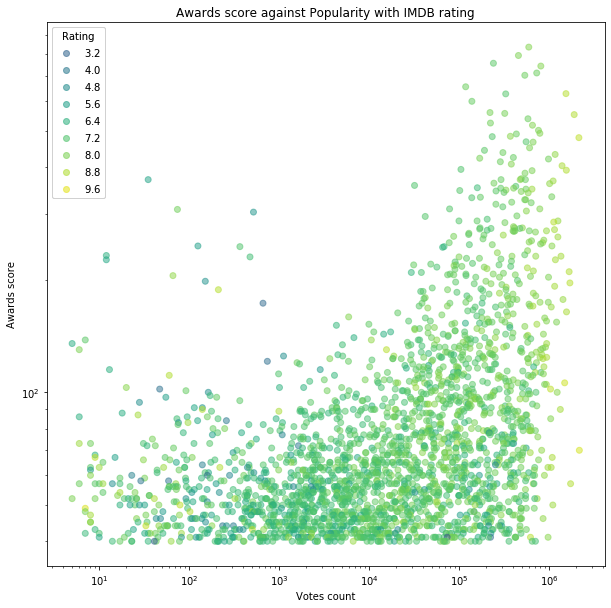

In [389]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

scatter = ax.scatter(top_recognized_movies['numVotes'],
            top_recognized_movies['recognition'],
            alpha=0.5,
            c=top_recognized_movies['averageRating'],
            vmin=0, vmax=10)
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", title="Rating")
ax.add_artist(legend1)
ax.set_title("Awards score against Popularity with IMDB rating")    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Votes count')
ax.set_ylabel('Awards score')
# ax.set_ylim(bottom=1)
plt.show()

In [390]:
# with pd.option_context('display.max_rows', 5000, 'display.max_columns', 20):
#     display(tconst_genders)